## Human in the loop concept

In [154]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import Chroma

import os


load_dotenv()

True

In [155]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")
os.environ['LANGGRAPH_PROJECT']="HITL"

In [156]:
@tool
def string_manipulation(string_value: str, task: str, splitter: str) -> dict:
    """
    Your task is to perform string manipulation based on user input.
    Task can include - upper, lower, split, reverse of strings provided by the user.
    splitter can be of type - (/ , .)
    """

    try: 
        if task=="upper":
            result=string_value.upper()
        elif task=="lower":
            result=string_value.upper()
        elif task=="reverse":
                result=string_value[::-1]
        elif task=="split":
            if splitter=="/":
                result=string_value.split('/') 
            elif splitter==",":
                result=string_value.split(',')
            elif splitter==".":
                result=string_value.split('.')
            else:
                return {"error":f"Unsupported splitter {splitter}"}
                
        else:
            return {"error":f"Unsupported task {task}"}
        
        return {"string_value":string_value,"task":task,"splitter": splitter, "result":result}
    except Exception as e:
        return {"error":str(e)}

In [157]:
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operations on the two numbers.
    Supported operations: add, sub, mul, div
    """

    try: 
        if operation=="add":
            result=first_num+second_num
        elif operation=="sub":
            result=first_num-second_num
        elif operation=="mul":
            result=first_num*second_num
        elif operation=="div":
            result=first_num/second_num
        else:
            return {"error":f"Unsupported operation {operation}"}
        
        return {"first_num":first_num,"second_num":second_num,"operation": operation, "result":result}
    except Exception as e:
        return {"error":str(e)}
        

In [158]:
# Get the directory where the notebook is located
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
pdf_path = os.path.join(notebook_dir, "RentalConditions.pdf")


pdf_loader= PyPDFLoader(pdf_path)
pdf_documents=pdf_loader.load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
pdf_splitted=splitter.split_documents(pdf_documents)

embeddings=OpenAIEmbeddings(model="text-embedding-3-small",dimensions=1024)
chromadatabase=Chroma.from_documents(pdf_splitted,embeddings)
chromdb_retrieved_docs=chromadatabase.as_retriever(search_kwargs={"k": 3})
retriver_tool=create_retriever_tool(chromdb_retrieved_docs,"Rental_Car_Retriever", "Rental car information to be pulled from this document")

In [159]:
tools = [string_manipulation,calculator,retriver_tool]

llm_with_tools= gpt_llm.bind_tools(tools)

In [160]:
sys_msg = SystemMessage(content="You are a helpful AI assistant that performs normal tool calls.")

In [161]:
def first_assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

In [162]:
graph = StateGraph(MessagesState)

graph.add_node("first_assistant",first_assistant)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"first_assistant")
graph.add_conditional_edges("first_assistant", tools_condition)
graph.add_edge("tools", "first_assistant")
graph.add_edge("first_assistant", END)

## Interrupt before - human in the loop

In [163]:
memory=MemorySaver()
workflow=graph.compile(interrupt_before=["first_assistant"],checkpointer=memory)

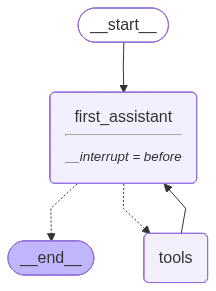

In [164]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [165]:
CONFIG=  {"configurable":{"thread_id":123}}

In [166]:
workflow.invoke({"messages":HumanMessage(content="how much is the security deposit?")},config=CONFIG)

{'messages': [HumanMessage(content='how much is the security deposit?', additional_kwargs={}, response_metadata={}, id='aa025b11-9b13-4e81-a853-b54bffe05824')]}

In [167]:
workflow.invoke(None,config=CONFIG)

{'messages': [HumanMessage(content='how much is the security deposit?', additional_kwargs={}, response_metadata={}, id='aa025b11-9b13-4e81-a853-b54bffe05824'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V7SibY31FsmrV2LT6SDrhkns', 'function': {'arguments': '{"query":"security deposit"}', 'name': 'Rental_Car_Retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 188, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CRWP21xkCDi6Sv9m8Ii9B0WfpI7cm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4e2dd85-a19d-419d-b0f2-a410885a9388-0', tool_calls=[{'name': 'Rental_Car_Retriever', 'ar

In [168]:
workflow.invoke(None,config=CONFIG)

{'messages': [HumanMessage(content='how much is the security deposit?', additional_kwargs={}, response_metadata={}, id='aa025b11-9b13-4e81-a853-b54bffe05824'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V7SibY31FsmrV2LT6SDrhkns', 'function': {'arguments': '{"query":"security deposit"}', 'name': 'Rental_Car_Retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 188, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CRWP21xkCDi6Sv9m8Ii9B0WfpI7cm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4e2dd85-a19d-419d-b0f2-a410885a9388-0', tool_calls=[{'name': 'Rental_Car_Retriever', 'ar

In [169]:
for event in workflow.stream({"messages":HumanMessage(content="how much is the security deposit?")},config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

how much is the security deposit?


In [170]:
for event in workflow.stream(None,config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

how much is the security deposit?
================================== Ai Message ==================================

The estimated security deposit amount for the car is 500.00 NZD. This deposit will be blocked on the driver's credit card upon collection of the car.


In [171]:
for event in workflow.stream(None,config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

The estimated security deposit amount for the car is 500.00 NZD. This deposit will be blocked on the driver's credit card upon collection of the car.


## Interrupt after -  human in the loop

In [172]:
memory=MemorySaver()
workflow=graph.compile(interrupt_after=["first_assistant"],checkpointer=memory)

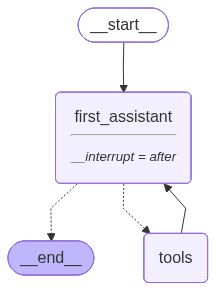

In [173]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [174]:
CONFIG=  {"configurable":{"thread_id":123}}

In [175]:
for event in workflow.stream({"messages":HumanMessage(content="how much is the security deposit?")},config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

how much is the security deposit?
================================== Ai Message ==================================
Tool Calls:
  Rental_Car_Retriever (call_2e1ajoAOQSsnwVXtcPVdAhjy)
 Call ID: call_2e1ajoAOQSsnwVXtcPVdAhjy
  Args:
    query: security deposit


In [176]:
for event in workflow.stream(None,config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Rental_Car_Retriever (call_2e1ajoAOQSsnwVXtcPVdAhjy)
 Call ID: call_2e1ajoAOQSsnwVXtcPVdAhjy
  Args:
    query: security deposit
================================= Tool Message =================================
Name: Rental_Car_Retriever

which is subject to be paid locally at the rental desk. Please be aware, that the information provided in this offer do not, and
are not intended to, constitute legal advice; instead, all information, and content available on this offer are for general
informational purposes only.
SECURITY DEPOSIT FOR THE CAR
Estimated deposit amount: 500.00 NZD
Upon collection of the car a security deposit will be blocked on the driver’s credit card. This deposit is determined by

which is subject to be paid locally at the rental desk. Please be aware, that the information provided in this offer do not, and
are not intended to, constitute legal advice; instead, all informati

In [177]:
for event in workflow.stream({"messages":HumanMessage(content="What is the reverse value of 'Gaurav Agarwal'")},config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the reverse value of 'Gaurav Agarwal'
================================== Ai Message ==================================
Tool Calls:
  string_manipulation (call_L26OCB5IDbtmbTTVsSztxuhA)
 Call ID: call_L26OCB5IDbtmbTTVsSztxuhA
  Args:
    string_value: Gaurav Agarwal
    task: reverse
    splitter:


In [178]:
for event in workflow.stream(None,config=CONFIG,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  string_manipulation (call_L26OCB5IDbtmbTTVsSztxuhA)
 Call ID: call_L26OCB5IDbtmbTTVsSztxuhA
  Args:
    string_value: Gaurav Agarwal
    task: reverse
    splitter:
================================= Tool Message =================================
Name: string_manipulation

{"string_value": "Gaurav Agarwal", "task": "reverse", "splitter": "", "result": "lawragA varuaG"}
================================== Ai Message ==================================

The reverse value of 'Gaurav Agarwal' is 'lawragA varuaG'.
